In [1]:
import torch
torch.cuda.empty_cache()
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

In [2]:
gdsc_df = pd.read_csv("dataset/GDSC_SMILES_merged.csv", index_col=0)
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O


In [3]:
ccl_rep_df = pd.read_csv("dataset/PANCANCER_Genetic_feature.csv")

# Pivot to get binary matrix: rows = cell lines, columns = features
binary_feature_matrix = ccl_rep_df.pivot_table(
    index="cell_line_name",
    columns="genetic_feature",
    values="is_mutated",
    fill_value=0
).astype(int)

In [4]:
binary_feature_matrix.columns = binary_feature_matrix.columns.astype(str)

In [5]:
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23132-87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42-MG-BA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451Lu,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR-75-30,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
huH-1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [6]:
binary_feature_matrix.index = binary_feature_matrix.index.str.upper()

In [7]:
import re

def clean_name(name):
    return re.sub(r'[^A-Za-z0-9]', '', name).upper()

### CCL embeddings

In [8]:
binary_feature_matrix.index = binary_feature_matrix.index.to_series().apply(clean_name)
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42MGBA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451LU,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR7530,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
HUH1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


### Drugs

In [9]:
gdsc_df["CLEAN_CELL_LINE"] = gdsc_df["CELL_LINE_NAME"].apply(clean_name)
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,CLEAN_CELL_LINE
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,PFSK1
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,A673
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES5
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES7
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,EW11
...,...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O,SNU175
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O,SNU407
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O,SNU61
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O,SNUC5


### Fingerprints

In [10]:
def compute_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * n_bits
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return list(fp)


In [11]:
unique_drugs = gdsc_df[["DRUG_ID", "SMILES"]].drop_duplicates().reset_index(drop=True)
unique_drugs["FINGERPRINT"] = unique_drugs["SMILES"].apply(compute_morgan)
fingerprint_dict = dict(zip(unique_drugs["DRUG_ID"], unique_drugs["FINGERPRINT"]))

[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerator
[16:32:27] DEPRECATION WARNING: please use MorganGenerat

# Creating Dataset

In [12]:
from rdkit import Chem
import torch
from torch_geometric.data import Data

from torch.utils.data import Dataset


In [13]:
# Define categorical vocabularies
ATOM_LIST = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H', 'B', 'Si', 'Na', 'K', 'Li', 'Mg', 'Ca', 'Fe', 'Zn', 'Se', 'Cu']
DEGREE_LIST = list(range(0, 11))
VALENCE_LIST = list(range(0, 7))
HYBRIDIZATION_LIST = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
TOTAL_H_LIST = [0, 1, 2, 3, 4]
CHIRALITY_LIST = ['R', 'S']

In [14]:
def one_hot_encoding(x, allowable):
    return [int(x == s) for s in allowable]

In [15]:
def atom_features(atom):
    features = []
    features += one_hot_encoding(atom.GetSymbol(), ATOM_LIST)
    features += one_hot_encoding(atom.GetDegree(), DEGREE_LIST)
    features += one_hot_encoding(atom.GetImplicitValence(), VALENCE_LIST)
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features += one_hot_encoding(atom.GetHybridization(), HYBRIDIZATION_LIST)
    features.append(int(atom.GetIsAromatic()))
    features += one_hot_encoding(atom.GetTotalNumHs(), TOTAL_H_LIST)
    features.append(int(atom.IsInRing()))
    
    chirality = atom.GetProp('_CIPCode') if atom.HasProp('_CIPCode') else None
    features += one_hot_encoding(chirality, CHIRALITY_LIST)
    
    return features


In [16]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_feats = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_feats, dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # undirected

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    return Data(x=x, edge_index=edge_index)

In [17]:
class MGATAFDataset(Dataset):
    def __init__(self, gdsc_df, fingerprint_dict, cell_feature_matrix, graph_dict):
        self.df = gdsc_df
        self.fingerprint_dict = fingerprint_dict
        self.cell_features = cell_feature_matrix
        self.graphs = graph_dict
        self.clean = lambda x: re.sub(r'[^A-Za-z0-9]', '', x).upper()
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug_id = row["DRUG_ID"]
        # cell_line_raw = row["CELL_LINE_NAME"]
        # cell_line = self.clean(cell_line_raw)
        cell_line = row["CLEAN_CELL_LINE"]

        # Graph
        graph_data = self.graphs[drug_id]

        # Fingerprint → Tensor
        fingerprint = torch.tensor(self.fingerprint_dict[drug_id], dtype=torch.float)

        # Cell line features → Tensor
        ccl_feat = torch.tensor(self.cell_features.loc[cell_line].values, dtype=torch.float)

        # Label → Tensor
        ic50 = torch.tensor([row["LN_IC50"]], dtype=torch.float)

        return graph_data, fingerprint, ccl_feat, ic50


In [18]:
# Step 1: Clean the GDSC cell line column
# gdsc_df["CELL_LINE_NAME_CLEAN"] = gdsc_df["CELL_LINE_NAME"].apply(clean_name)

# Step 2: Clean the index of the binary feature matrix
binary_feature_matrix.index = binary_feature_matrix.index.to_series().apply(clean_name)
binary_feature_matrix = binary_feature_matrix[~binary_feature_matrix.index.duplicated(keep='first')]

# Step 3: Filter only rows where:
# - drug_id in fingerprint_dict
# - cleaned cell line in binary_feature_matrix index
# - SMILES is not null (and possibly valid)

valid_drugs = set(fingerprint_dict.keys())
valid_cell_lines = set(binary_feature_matrix.index)

# Final filtering
gdsc_df = gdsc_df[
    gdsc_df["DRUG_ID"].isin(valid_drugs) &
    gdsc_df["CLEAN_CELL_LINE"].isin(valid_cell_lines) &
    gdsc_df["SMILES"].notna()
].reset_index(drop=True)

# Normalise the ln IC50 values
gdsc_df['LN_IC50'] = 1 / (np.exp(-0.1 * gdsc_df['LN_IC50']) + 1)

In [19]:
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,CLEAN_CELL_LINE
0,1003,Camptothecin,PFSK-1,0.463511,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,PFSK1
1,1003,Camptothecin,A673,0.380614,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,A673
2,1003,Camptothecin,ES5,0.416765,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES5
3,1003,Camptothecin,ES7,0.376483,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES7
4,1003,Camptothecin,EW-11,0.407536,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,EW11
...,...,...,...,...,...,...
193910,2499,N-acetyl cysteine,SNU-175,0.733695,CC(=O)NC(CS)C(=O)O,SNU175
193911,2499,N-acetyl cysteine,SNU-407,0.702150,CC(=O)NC(CS)C(=O)O,SNU407
193912,2499,N-acetyl cysteine,SNU-61,0.741172,CC(=O)NC(CS)C(=O)O,SNU61
193913,2499,N-acetyl cysteine,SNU-C5,0.744624,CC(=O)NC(CS)C(=O)O,SNUC5


In [20]:
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42MGBA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451LU,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR7530,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
HUH1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [21]:
drug_smiles = gdsc_df.drop_duplicates(subset="DRUG_ID")[["DRUG_ID", "SMILES"]]

In [22]:
precomputed_graphs = {}
for _, row in drug_smiles.iterrows():
    drug_id = row["DRUG_ID"]
    smi = row["SMILES"]
    graph = smiles_to_graph(smi)
    if graph is not None:
        precomputed_graphs[drug_id] = graph

In [23]:
# dataset = MGATAFDataset(
#     gdsc_df=gdsc_df,
#     fingerprint_dict=fingerprint_dict,
#     cell_feature_matrix=binary_feature_matrix,
#     graph_dict=precomputed_graphs
# )

In [24]:
# a=list(valid_cell_lines)

In [25]:
# a= np.array(list(valid_cell_lines))
# print(a)
# b= [1,2,3]
# print(b)
# print(np.array(b))

In [26]:
print(f"Total {len(valid_cell_lines)} common cell lines")
valid_cell_lines = np.array(list(valid_cell_lines))
np.random.shuffle(valid_cell_lines)
cell_lines_train = valid_cell_lines[: int(0.8*valid_cell_lines.shape[0])]
cell_lines_test = valid_cell_lines[int(0.8*valid_cell_lines.shape[0]) : int(0.9*valid_cell_lines.shape[0])]
cell_lines_val = valid_cell_lines[int(0.9*valid_cell_lines.shape[0]):]
print(f"Train: {cell_lines_train.shape[0]} cell lines")
print(f"Test: {cell_lines_test.shape[0]} cell lines")
print(f"Val: {cell_lines_val.shape[0]} cell lines")

train_set = MGATAFDataset(
    gdsc_df=gdsc_df[gdsc_df["CLEAN_CELL_LINE"].isin(cell_lines_train)].reset_index(drop=True),
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    graph_dict=precomputed_graphs
)
val_set = MGATAFDataset(
    gdsc_df=gdsc_df[gdsc_df["CLEAN_CELL_LINE"].isin(cell_lines_val)].reset_index(drop=True),
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    graph_dict=precomputed_graphs
)
test_set = MGATAFDataset(
    gdsc_df=gdsc_df[gdsc_df["CLEAN_CELL_LINE"].isin(cell_lines_test)].reset_index(drop=True),
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    graph_dict=precomputed_graphs
)

print(f"Train: {len(train_set)} pairs")
print(f"Val: {len(val_set)} pairs")
print(f"Val: {len(test_set)} pairs")

Total 988 common cell lines
Train: 790 cell lines
Test: 99 cell lines
Val: 99 cell lines
Train: 155432 pairs
Val: 18986 pairs
Val: 19497 pairs


In [27]:
sample = train_set[0]
graph, fingerprint, cell_feat, label = sample

print("Graph:")
print(graph)
print("Graph node features shape:", graph.x.shape)
print("Graph edge_index shape:", graph.edge_index.shape)
print()

print("Fingerprint shape:", fingerprint.shape)
print("Cell line features shape:", cell_feat.shape)
print("Label (ln_IC50):", label)


Graph:
Data(x=[26, 55], edge_index=[2, 60])
Graph node features shape: torch.Size([26, 55])
Graph edge_index shape: torch.Size([2, 60])

Fingerprint shape: torch.Size([2048])
Cell line features shape: torch.Size([735])
Label (ln_IC50): tensor([0.4635])


In [28]:
from torch_geometric.data import Batch

def mgataf_collate_fn(batch):
    graphs, fingerprints, ccl_feats, labels = zip(*batch)

    # Batch graph objects using PyG's helper
    graph_batch = Batch.from_data_list(graphs)

    # Stack everything else as tensors
    fingerprint_batch = torch.stack(fingerprints)
    ccl_feat_batch = torch.stack(ccl_feats)
    label_batch = torch.stack(labels)

    return graph_batch, fingerprint_batch, ccl_feat_batch, label_batch


# Model Build

## Encoding

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_add_pool

In [30]:
class DrugGraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_dim=128, num_layers=3, heads=4):
        super().__init__()
        self.gats = nn.ModuleList()
        self.num_layers = num_layers
        self.att_proj = nn.Linear(hidden_dim, 1)

        self.gats.append(GATConv(in_dim, hidden_dim, heads=heads, concat=False))
        for _ in range(1, num_layers):
            self.gats.append(GATConv(hidden_dim, hidden_dim, heads=heads, concat=False))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        layer_outputs = []

        for gat in self.gats:
            x = F.relu(gat(x, edge_index))
            pooled = global_add_pool(x, batch)
            layer_outputs.append(pooled)

        h = torch.stack(layer_outputs, dim=1)  # [B, L, D]
        attn_weights = F.softmax(self.att_proj(h).squeeze(-1), dim=1)  # [B, L]
        h_weighted = (h * attn_weights.unsqueeze(-1)).sum(dim=1)  # [B, D]
        return h_weighted

In [31]:
class FingerprintEncoder(nn.Module):
    def __init__(self, in_dim=2048, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        # Dummy pass to infer output size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            conv_flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.fc(x)
        return x


In [32]:
class CellLineEncoder(nn.Module):
    def __init__(self, in_dim=735, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        # Dynamically infer flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 735]
        x = self.conv(x)
        x = self.fc(x)
        return x


## Adaptive Fusion

In [33]:
class AdaptiveFusion(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gate_layer = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        # x1: drug + fp, x2: ccl
        concat = torch.cat([x1, x2], dim=1)
        gate = self.gate_layer(concat)

        fused = gate * x1 + (1 - gate) * x2
        return fused


## Final Dense Layer

In [34]:
class IC50Predictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


## Complete Model

In [35]:
class MGATAFModel(nn.Module):
    def __init__(self, atom_feat_dim=55, fingerprint_dim=2048, ccl_dim=735, hidden_dim=128):
        super().__init__()
        self.drug_encoder = DrugGraphEncoder(in_dim=atom_feat_dim, hidden_dim=hidden_dim)
        self.fp_encoder = FingerprintEncoder(in_dim=fingerprint_dim, out_dim=hidden_dim)
        self.ccl_encoder = CellLineEncoder(in_dim=ccl_dim, out_dim=hidden_dim)
        self.drug_fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)
        self.fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)
        self.regressor = IC50Predictor(input_dim=hidden_dim)

    def forward(self, graph_data, fingerprint, ccl_feat):
        drug_repr = self.drug_encoder(graph_data)
        fp_repr = self.fp_encoder(fingerprint)
        # drug_combined = drug_repr + fp_repr
        drug_combined = self.drug_fusion(drug_repr, fp_repr)

        ccl_repr = self.ccl_encoder(ccl_feat)
        fused = self.fusion(drug_combined, ccl_repr)

        return self.regressor(fused)


# Training

### Data Split

In [36]:
# from sklearn.model_selection import train_test_split

# indices = list(range(len(dataset)))
# train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=42)
# train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

# from torch.utils.data import Subset
# train_set = Subset(dataset, train_idx)
# val_set = Subset(dataset, val_idx)
# test_set = Subset(dataset, test_idx)

### Creating DataLoaders

In [37]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=mgataf_collate_fn)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=mgataf_collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=mgataf_collate_fn)

### Training Loop

In [38]:
torch.backends.cudnn.benchmark = True

In [39]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
Device name: NVIDIA RTX 6000 Ada Generation


In [40]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

import os

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MGATAFModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
patience_counter = 0
max_patience = 10
num_epochs = 100


# Trackers
train_rmse_list = []
val_rmse_list = []
val_pcc_list = []


# Paths
checkpoint_model_path = "models/mgataf_best_model.pt"
checkpoint_opt_path = "models/mgataf_best_optim.pt"
checkpoint_meta_path = "models/mgataf_best_meta.pt"

# Defaults
start_epoch = 0

# Resume
if os.path.exists(checkpoint_model_path) and os.path.exists(checkpoint_opt_path) and os.path.exists(checkpoint_meta_path):
    print("🔄 Resuming model...")
    model.load_state_dict(torch.load(checkpoint_model_path))

    # if os.path.exists(checkpoint_opt_path):
    optimizer.load_state_dict(torch.load(checkpoint_opt_path))

    # if os.path.exists(checkpoint_meta_path):
    meta = torch.load(checkpoint_meta_path)
    start_epoch = meta["epoch"] + 1
    best_val_loss = meta["best_val_loss"]
    patience_counter = meta["patience_counter"]

    print(f"✅ Resumed from epoch {start_epoch} | Best Val Loss: {best_val_loss:.4f}")


for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    train_preds, train_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    for batch_idx, (graph_data, fingerprint, ccl_feat, label) in enumerate(loop):
        graph_data = graph_data.to(device)
        fingerprint = fingerprint.to(device)
        ccl_feat = ccl_feat.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(graph_data, fingerprint, ccl_feat)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_preds.append(output.detach().cpu().numpy())
        train_labels.append(label.cpu().numpy())
        
        # Every N batches, compute and show running metrics
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            pred_flat = np.concatenate(train_preds).flatten()
            label_flat = np.concatenate(train_labels).flatten()
            rmse = root_mean_squared_error(label_flat, pred_flat)
            try:
                pcc = pearsonr(label_flat, pred_flat)[0]
            except:
                pcc = float('nan')

            loop.set_postfix(train_rmse=f"{rmse:.4f}", train_pcc=f"{pcc:.4f}")

        # loop.set_postfix(train_loss=loss.item())

    train_preds_flat = np.concatenate(train_preds).flatten()
    train_labels_flat = np.concatenate(train_labels).flatten()
    train_rmse = root_mean_squared_error(train_labels_flat, train_preds_flat)
    train_rmse_list.append(train_rmse)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for graph_data, fingerprint, ccl_feat, label in val_loader:
            graph_data = graph_data.to(device)
            fingerprint = fingerprint.to(device)
            ccl_feat = ccl_feat.to(device)
            label = label.to(device)

            output = model(graph_data, fingerprint, ccl_feat)
            val_preds.append(output.cpu().numpy())
            val_labels.append(label.cpu().numpy())

    val_preds_flat = np.concatenate(val_preds).flatten()
    val_labels_flat = np.concatenate(val_labels).flatten()
    val_rmse = root_mean_squared_error(val_labels_flat, val_preds_flat)
    val_pcc = pearsonr(val_preds_flat, val_labels_flat)[0]

    val_rmse_list.append(val_rmse)
    val_pcc_list.append(val_pcc)

    scheduler.step(val_rmse)

    print(f"[Epoch {epoch+1}] Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")

    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), "models/mgataf_best_model.pt")
        torch.save(optimizer.state_dict(), "models/mgataf_best_optim.pt")
        torch.save({
            "epoch": epoch,
            "best_val_loss": best_val_loss,
            "patience_counter": patience_counter
        }, "models/mgataf_best_meta.pt")
        print(f"[Saved Best Model and State] | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break


Epoch 1: 100%|██████████| 4858/4858 [01:38<00:00, 49.12it/s, train_pcc=0.8329, train_rmse=0.0383]


[Epoch 1] Train RMSE: 0.0383 | Val RMSE: 0.0386 | Val PCC: 0.8431
[Saved Best Model and State] | Val RMSE: 0.0386 | Val PCC: 0.8431


Epoch 2: 100%|██████████| 4858/4858 [01:37<00:00, 49.68it/s, train_pcc=0.8954, train_rmse=0.0306]


[Epoch 2] Train RMSE: 0.0306 | Val RMSE: 0.0410 | Val PCC: 0.8367


Epoch 3: 100%|██████████| 4858/4858 [01:39<00:00, 49.04it/s, train_pcc=0.9083, train_rmse=0.0288]


[Epoch 3] Train RMSE: 0.0288 | Val RMSE: 0.0382 | Val PCC: 0.8406
[Saved Best Model and State] | Val RMSE: 0.0382 | Val PCC: 0.8406


Epoch 4: 100%|██████████| 4858/4858 [01:38<00:00, 49.08it/s, train_pcc=0.9167, train_rmse=0.0275]


[Epoch 4] Train RMSE: 0.0275 | Val RMSE: 0.0388 | Val PCC: 0.8376


Epoch 5: 100%|██████████| 4858/4858 [01:34<00:00, 51.54it/s, train_pcc=0.9219, train_rmse=0.0266]


[Epoch 5] Train RMSE: 0.0266 | Val RMSE: 0.0385 | Val PCC: 0.8381


Epoch 6: 100%|██████████| 4858/4858 [01:29<00:00, 54.42it/s, train_pcc=0.9261, train_rmse=0.0259]


[Epoch 6] Train RMSE: 0.0259 | Val RMSE: 0.0381 | Val PCC: 0.8391
[Saved Best Model and State] | Val RMSE: 0.0381 | Val PCC: 0.8391


Epoch 7: 100%|██████████| 4858/4858 [01:37<00:00, 49.85it/s, train_pcc=0.9290, train_rmse=0.0254]


[Epoch 7] Train RMSE: 0.0254 | Val RMSE: 0.0387 | Val PCC: 0.8338


Epoch 8: 100%|██████████| 4858/4858 [01:27<00:00, 55.29it/s, train_pcc=0.9317, train_rmse=0.0250]


[Epoch 8] Train RMSE: 0.0250 | Val RMSE: 0.0385 | Val PCC: 0.8355


Epoch 9: 100%|██████████| 4858/4858 [01:31<00:00, 53.21it/s, train_pcc=0.9338, train_rmse=0.0246]


[Epoch 9] Train RMSE: 0.0246 | Val RMSE: 0.0392 | Val PCC: 0.8313


Epoch 10: 100%|██████████| 4858/4858 [01:34<00:00, 51.42it/s, train_pcc=0.9361, train_rmse=0.0242]


[Epoch 10] Train RMSE: 0.0242 | Val RMSE: 0.0390 | Val PCC: 0.8309


Epoch 11: 100%|██████████| 4858/4858 [01:37<00:00, 49.81it/s, train_pcc=0.9376, train_rmse=0.0239]


[Epoch 11] Train RMSE: 0.0239 | Val RMSE: 0.0390 | Val PCC: 0.8362


Epoch 12: 100%|██████████| 4858/4858 [01:32<00:00, 52.61it/s, train_pcc=0.9391, train_rmse=0.0236]


[Epoch 12] Train RMSE: 0.0236 | Val RMSE: 0.0394 | Val PCC: 0.8284


Epoch 13: 100%|██████████| 4858/4858 [01:36<00:00, 50.13it/s, train_pcc=0.9448, train_rmse=0.0225]


[Epoch 13] Train RMSE: 0.0225 | Val RMSE: 0.0393 | Val PCC: 0.8291


Epoch 14: 100%|██████████| 4858/4858 [01:36<00:00, 50.43it/s, train_pcc=0.9462, train_rmse=0.0222]


[Epoch 14] Train RMSE: 0.0222 | Val RMSE: 0.0394 | Val PCC: 0.8290


Epoch 15: 100%|██████████| 4858/4858 [01:39<00:00, 48.62it/s, train_pcc=0.9470, train_rmse=0.0221]


[Epoch 15] Train RMSE: 0.0221 | Val RMSE: 0.0393 | Val PCC: 0.8276


Epoch 16: 100%|██████████| 4858/4858 [01:30<00:00, 53.51it/s, train_pcc=0.9478, train_rmse=0.0219]


[Epoch 16] Train RMSE: 0.0219 | Val RMSE: 0.0400 | Val PCC: 0.8281
Early stopping triggered.


Split the dataset on DRUGS to ensure there are no dataleaks!!!

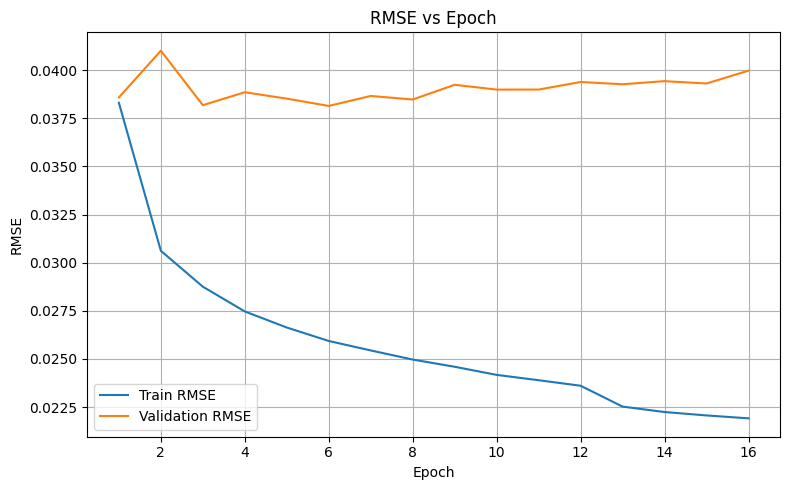

In [42]:
# Plot RMSE vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label="Train RMSE")
plt.plot(range(1, len(val_rmse_list)+1), val_rmse_list, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing and Evaluation

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize model
model = MGATAFModel().to(device)

# Load best saved weights
model.load_state_dict(torch.load("models/mgataf_best_model.pt"))
model.eval()

MGATAFModel(
  (drug_encoder): DrugGraphEncoder(
    (gats): ModuleList(
      (0): GATConv(55, 128, heads=4)
      (1-2): 2 x GATConv(128, 128, heads=4)
    )
    (att_proj): Linear(in_features=128, out_features=1, bias=True)
  )
  (fp_encoder): FingerprintEncoder(
    (conv): Sequential(
      (0): Conv1d(1, 32, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
      (3): ReLU()
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=16256, out_features=128, bias=True)
      (2): ReLU()
    )
  )
  (ccl_encoder): CellLineEncoder(
    (conv): Sequential(
      (0): Conv1d(1, 32, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
      (3): ReLU()
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=5760, out_features=128, bias=True)
      (2): ReLU()
    )
  )
  (drug_fusion): Adapt

In [44]:
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for graph_data, fingerprint, ccl_feat, label in test_loader:
        graph_data = graph_data.to(device)
        fingerprint = fingerprint.to(device)
        ccl_feat = ccl_feat.to(device)
        label = label.to(device)

        preds = model(graph_data, fingerprint, ccl_feat)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Flatten predictions and labels
y_pred = np.concatenate(all_preds).flatten()
y_true = np.concatenate(all_labels).flatten()

# Compute metrics
test_rmse = root_mean_squared_error(y_true, y_pred)
test_pcc = pearsonr(y_true, y_pred)[0]

print(f"✅ Test RMSE: {test_rmse:.4f}")
print(f"✅ Test PCC:  {test_pcc:.4f}")


✅ Test RMSE: 0.0388
✅ Test PCC:  0.8274


Fusion:
✅ Test RMSE: 0.0396
✅ Test PCC:  0.8202

Summation:
✅ Test RMSE: 0.0356
✅ Test PCC:  0.8554

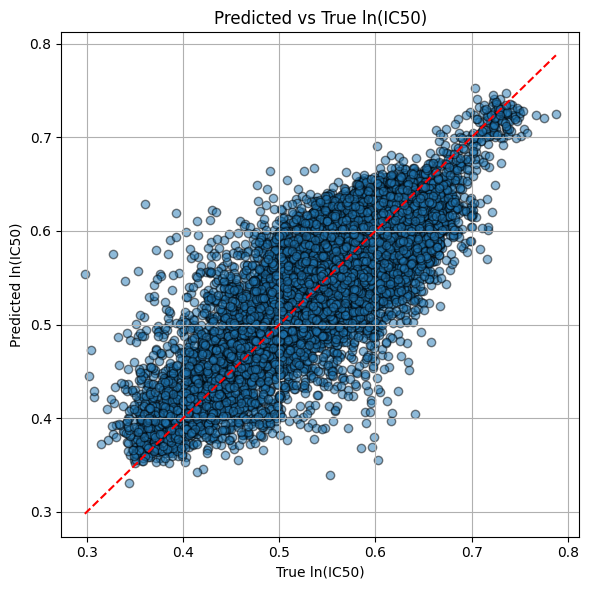

In [45]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True ln(IC50)")
plt.ylabel("Predicted ln(IC50)")
plt.title("Predicted vs True ln(IC50)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
def print_parameter_breakdown(model):
    total = 0
    print("\nTrainable Parameters by Module:\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            count = param.numel()
            print(f"{name:<50} {count:>10}")
            total += count
    print(f"\nTotal Trainable Parameters: {total:,}")

print_parameter_breakdown(model)



Trainable Parameters by Module:

drug_encoder.gats.0.att_src                               512
drug_encoder.gats.0.att_dst                               512
drug_encoder.gats.0.bias                                  128
drug_encoder.gats.0.lin.weight                          28160
drug_encoder.gats.1.att_src                               512
drug_encoder.gats.1.att_dst                               512
drug_encoder.gats.1.bias                                  128
drug_encoder.gats.1.lin.weight                          65536
drug_encoder.gats.2.att_src                               512
drug_encoder.gats.2.att_dst                               512
drug_encoder.gats.2.bias                                  128
drug_encoder.gats.2.lin.weight                          65536
drug_encoder.att_proj.weight                              128
drug_encoder.att_proj.bias                                  1
fp_encoder.conv.0.weight                                  256
fp_encoder.conv.0.bias              